___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-3 (RNN)<br><br>Product Amount Forecast by Time<br><h1>

# Dataset Info

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [1]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Indest Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DL-Assignment_3_(ML_1022_EU)/Frozen_Dessert_Production.csv', parse_dates=['DATE'], index_col='DATE')

In [5]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


# Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [7]:
df.columns = ['Production'] # Rename the column as Production

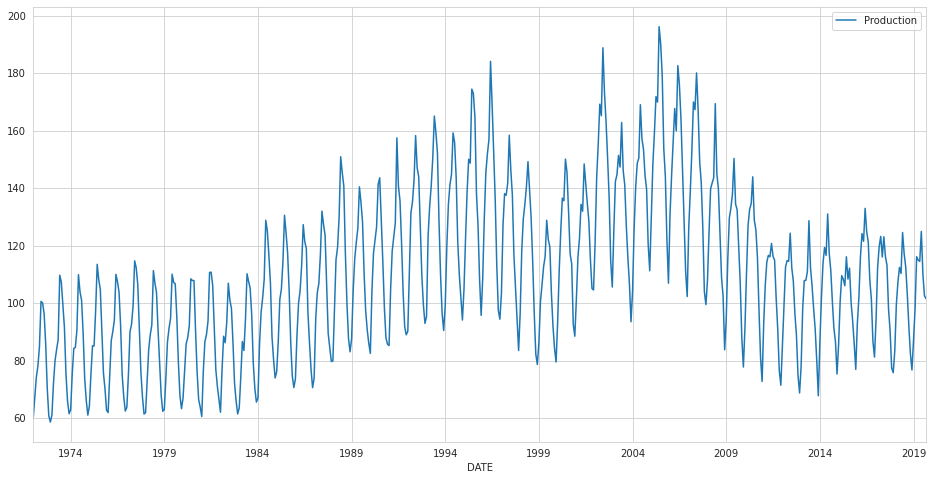

In [8]:
df.plot(figsize=(16,8)) # plot the data

In [9]:
df.duplicated().sum() # No duplicates

0

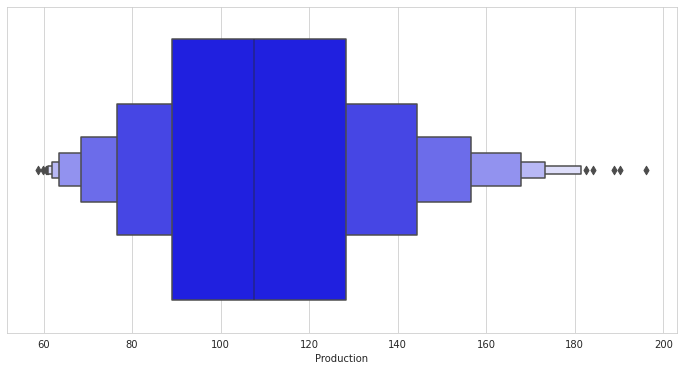

In [10]:
sns.boxenplot(df['Production'], color="blue" ); # Box plot

# Preprocessing of Data

## Train Test Split

In [11]:
len(df)

573

In [12]:
test_size = 24 # 24 months 

In [13]:
test_ind = len(df) -test_size 
test_ind 

549

In [14]:
train = df.iloc[:test_ind] # Training data
test = df.iloc[test_ind:] # Testing data

In [15]:
train

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2017-05-01,116.064
2017-06-01,123.087
2017-07-01,116.264


In [16]:
test.head()

,Production
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490


## Scaling

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
train_scaled = scaler.fit_transform(train) # Scaling the training data
test_scaled = scaler.transform(test)        # Scaling the testing data

## Time Series Generator

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
length = 12 # 12 months
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=batch_size)

In [22]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]), array([[0.01774221]]))

In [23]:
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


# Modelling & Model Performance

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

## with "tanh" activation function

In [25]:
n_features = train_scaled.shape[1]

In [26]:
model = Sequential() 
model.add(LSTM(100, activation='tanh', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping and Validation Generator

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=10) # patience: number of epochs with no improvement after which training will be stoppe

In [30]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=length, batch_size=batch_size)

In [31]:
model.fit(generator, epochs=50, callbacks=[early_stop], validation_data=validation_generator) 

Epoch 1/50
537/537 [==============================] - 11s 7ms/step - loss: 0.0198 - val_loss: 0.0016
Epoch 2/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 3/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 4/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 5/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 7/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 8/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 9/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 10/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0030 - val_loss: 0.002

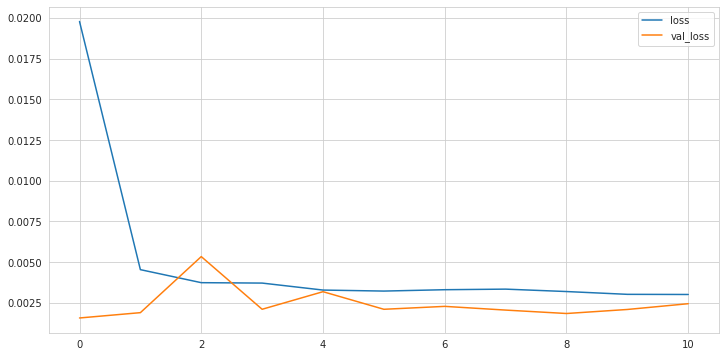

In [32]:
loss_df = pd.DataFrame(model.history.history)   
loss_df.plot() 

### Evaluation on Test Data

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [35]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [36]:
predictions_scaled

[array([0.26842177], dtype=float32),
 array([0.2650144], dtype=float32),
 array([0.29723844], dtype=float32),
 array([0.35090032], dtype=float32),
 array([0.40674597], dtype=float32),
 array([0.4537002], dtype=float32),
 array([0.48675433], dtype=float32),
 array([0.5013653], dtype=float32),
 array([0.49585977], dtype=float32),
 array([0.46655032], dtype=float32),
 array([0.42221126], dtype=float32),
 array([0.3757185], dtype=float32)]

In [37]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.13717638502710183 
mae: 0.08976818105021188 
mse: 0.010759961644942253 
rmse: 0.10373023496041187


### Inverse Transformation and Comparing

In [38]:
predictions = scaler.inverse_transform(predictions_scaled)

In [39]:
compare = test[:12]
compare['Predictions'] = predictions
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,95.572
2017-11-01,77.438,95.103
2017-12-01,75.812,99.534
2018-01-01,83.434,106.913
2018-02-01,99.490,114.593
2018-03-01,107.315,121.050
2018-04-01,112.431,125.595
2018-05-01,110.354,127.604
2018-06-01,124.584,126.847


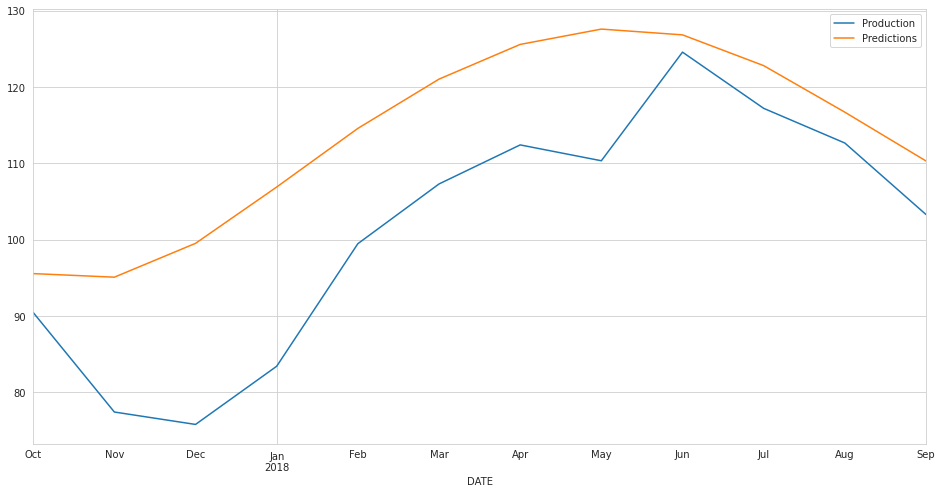

In [40]:
compare.plot(figsize=(16,8));

In [41]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.13717638502710316 
mae: 12.344372672120722 
mse: 203.47165688200917 
rmse: 14.264349157322572


## with "relu" activation function

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [43]:
n_features = train_scaled.shape[1]

In [44]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [46]:
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [48]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [49]:
model.fit(generator, epochs = 50, callbacks = [early_stop], validation_data = validation_generator)

Epoch 1/50
537/537 [==============================] - 19s 31ms/step - loss: 0.0247 - val_loss: 0.0132
Epoch 2/50
537/537 [==============================] - 12s 22ms/step - loss: 0.0083 - val_loss: 0.0020
Epoch 3/50
537/537 [==============================] - 12s 21ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 4/50
537/537 [==============================] - 12s 22ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 5/50
537/537 [==============================] - 16s 30ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 6/50
537/537 [==============================] - 17s 32ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 7/50
537/537 [==============================] - 14s 25ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 8/50
537/537 [==============================] - 20s 37ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 9/50
537/537 [==============================] - 14s 26ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 10/50
537/537 [==============================] - 18s 33ms/step - loss: 0.003

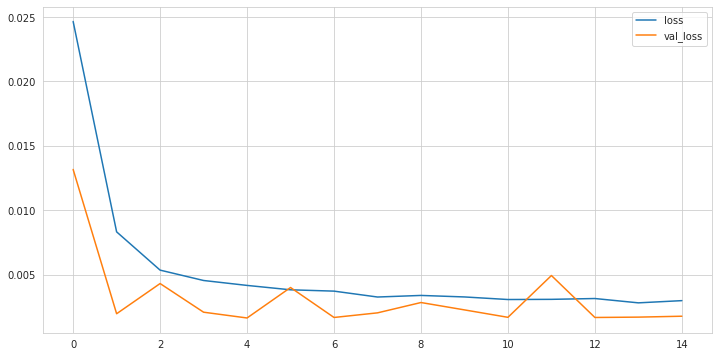

In [50]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [51]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [52]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.26454396747262776 
mae: 0.08210932443975477 
mse: 0.009171606530246039 
rmse: 0.09576850489720531


### Inverse Transformation and Comparing

In [53]:
predictions = scaler.inverse_transform(predictions_scaled)

In [54]:
compare = test[:12]
compare['Predictions'] = predictions
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,94.667
2017-11-01,77.438,90.255
2017-12-01,75.812,93.405
2018-01-01,83.434,104.189
2018-02-01,99.490,114.423
2018-03-01,107.315,122.638
2018-04-01,112.431,127.796
2018-05-01,110.354,130.293
2018-06-01,124.584,129.180


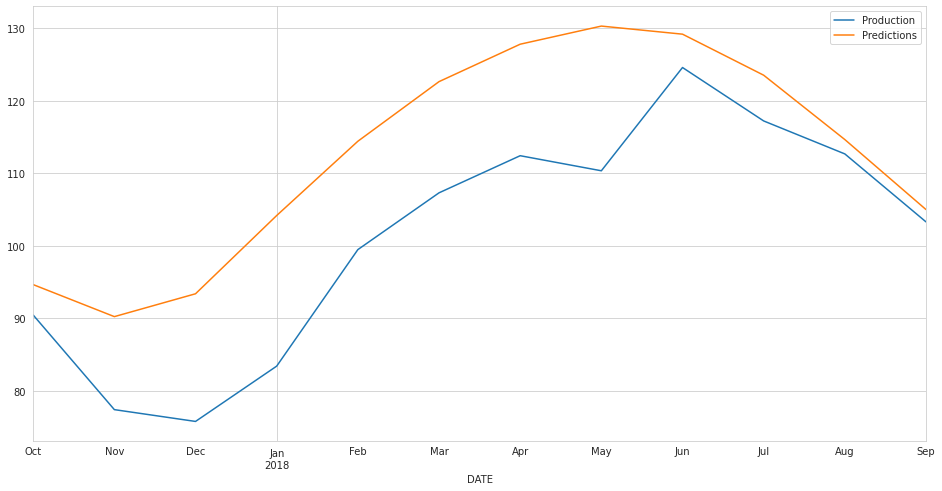

In [55]:
compare.plot(figsize=(16,8));

In [56]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.26454396747262854 
mae: 11.291173430075991 
mse: 173.43574620047198 
rmse: 13.169500605583796


# Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [57]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [58]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=batch_size)

In [59]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=28, verbose=1)

Epoch 1/28
561/561 [==============================] - 13s 21ms/step - loss: 0.0183
Epoch 2/28
561/561 [==============================] - 12s 21ms/step - loss: 0.0065
Epoch 3/28
561/561 [==============================] - 12s 22ms/step - loss: 0.0045
Epoch 4/28
561/561 [==============================] - 12s 21ms/step - loss: 0.0047
Epoch 5/28
561/561 [==============================] - 12s 21ms/step - loss: 0.0039
Epoch 6/28
561/561 [==============================] - 12s 21ms/step - loss: 0.0039
Epoch 7/28
561/561 [==============================] - 14s 24ms/step - loss: 0.0037
Epoch 8/28
561/561 [==============================] - 12s 21ms/step - loss: 0.0034
Epoch 9/28
561/561 [==============================] - 12s 22ms/step - loss: 0.0032
Epoch 10/28
561/561 [==============================] - 12s 22ms/step - loss: 0.0032
Epoch 11/28
561/561 [==============================] - 12s 21ms/step - loss: 0.0030
Epoch 12/28
561/561 [==============================] - 12s 21ms/step - loss: 0.0028
E

In [60]:
scaled_full_data.shape

(573, 1)

In [61]:
scaled_full_data[-length:].shape

(12, 1)

In [62]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [63]:
forecast = scaler.inverse_transform(forecast) # undo scaling

In [64]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')

In [65]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [66]:
forecast_df

,Forecast
2019-10-01,88.379
2019-11-01,82.425
2019-12-01,82.591
2020-01-01,94.027
2020-02-01,107.666
2020-03-01,118.586
2020-04-01,126.031
2020-05-01,132.459
2020-06-01,134.211
2020-07-01,126.158


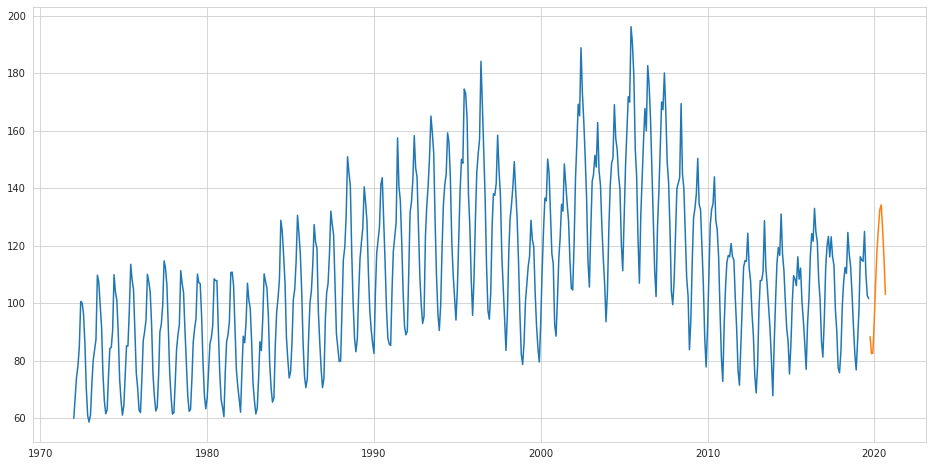

In [67]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast']);

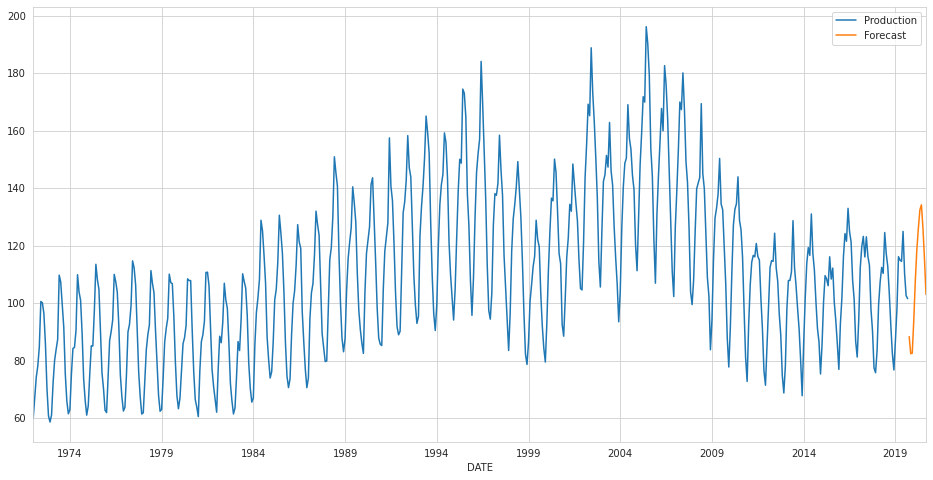

In [68]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___